# Train a Simple Machine Learning Model Using Julia

![Julia Logo](https://saturn-public-assets.s3.us-east-2.amazonaws.com/example-resources/julia-logo.png "doc-image")

## Overview

This example describes how to run a neural learning workflow using the famous MNIST dataset of handwritten digits. Flux.jl is a powerful Julia library for many types of machine learning, including neural networks. We will training a neural network on images of handwritten numbers to create an image classifier. 

## Modeling Process

### Imports
This exercise uses [Flux](https://fluxml.ai/Flux.jl/stable/) to train a simple neural network. The code loads several functions from Flux as well as some base functions.

In [1]:
using Flux, Flux.Data.MNIST
using CUDA
using Flux: onehotbatch, argmax, crossentropy, throttle, @epochs
using Base.Iterators: repeated
using Images

We can then check to see if CUDA is enabled. This will allow the model to run on the GPU instead of the CPU. This is potentially faster to train, but the speedup depends on a lot of factors.

In [2]:
CUDA.functional()

true

### Download and Examine the Dataset
First, we need to download the dataset. Flux has several built-in datasets, including MNIST. We can then take a look at the first image to see the type of data we are dealing with.

┌ Warning: Flux's datasets are deprecated, please use the package MLDatasets.jl
└ @ Flux.Data /srv/julia/packages/Flux/qAdFM/src/data/Data.jl:16


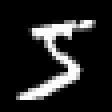

In [3]:
imgs = MNIST.images();
colorview(Gray, imgs[1])

In [4]:
labels = MNIST.labels();
labels[1]

┌ Warning: Flux's datasets are deprecated, please use the package MLDatasets.jl
└ @ Flux.Data /srv/julia/packages/Flux/qAdFM/src/data/Data.jl:16


5

We next convert the data into float32s to speed up training and reduce memory footprint while retaining precision.

In [5]:
float32converter(X) = Float32.(X)
f32_imgs = float32converter.(imgs)

60000-element Vector{Matrix{Float32}}:
 [0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0; … ; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0]
 [0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0; … ; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0]
 [0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0; … ; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0]
 [0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0; … ; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0]
 [0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0; … ; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0]
 [0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0; … ; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0]
 [0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0; … ; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0]
 [0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0; … ; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0]
 [0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0; … ; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0]
 [0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0; … ; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0]
 [0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0; … ; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0]
 [0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0; … ; 0.0 0.0 … 0.0 0

We then convert the individual images to a single vector of size 784 (28x28) by 60000 (the number of images).

In [6]:
vectorize(x) = x[:]
vectorized_imgs = vectorize.(f32_imgs);

In [7]:
X = hcat(vectorized_imgs...)
size(X)

(784, 60000)

To look at only one image, we have to select a column and reshape.

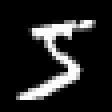

In [8]:
one_image = X[:,1]
image_1 = reshape(one_image,28,28)
colorview(Gray,image_1)

Lastly, we transform the labels from digits to one-hot vectors. For example, if the label is 3, the y value will be [0 0 0 1 0 0 0 0 0 0].

In [9]:
y = onehotbatch(labels, 0:9)

10×60000 OneHotMatrix(::Vector{UInt32}) with eltype Bool:
 ⋅  1  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  …  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅
 ⋅  ⋅  ⋅  1  ⋅  ⋅  1  ⋅  1  ⋅  ⋅  ⋅  ⋅     ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  1  ⋅  ⋅  ⋅  ⋅  ⋅
 ⋅  ⋅  ⋅  ⋅  ⋅  1  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅     ⋅  ⋅  ⋅  1  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅
 ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  1  ⋅  ⋅  1  ⋅  1     ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  1  ⋅  ⋅  ⋅
 ⋅  ⋅  1  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  1  ⋅  ⋅  ⋅     ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅
 1  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  1  ⋅  …  ⋅  ⋅  ⋅  ⋅  ⋅  1  ⋅  ⋅  ⋅  1  ⋅  ⋅
 ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅     ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  1  ⋅
 ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅     1  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅
 ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅     ⋅  1  ⋅  ⋅  ⋅  ⋅  ⋅  1  ⋅  ⋅  ⋅  1
 ⋅  ⋅  ⋅  ⋅  1  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅     ⋅  ⋅  1  ⋅  1  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅

### Build and Train the Model
Now we will actually build out neural network model. We will use a 32 node hidden layer and a 10 node output layer.

In [10]:
model = Chain(
        Dense(28^2, 32, relu),
        Dense(32, 10),
        softmax)

Chain(
  Dense(784, 32, relu),                 # 25_120 parameters
  Dense(32, 10),                        # 330 parameters
  NNlib.softmax,
)                   # Total: 4 arrays, 25_450 parameters, 99.664 KiB.

If we take a look at the output of the model now, we can see that it was initialized without any knowledge of the input. Each digit is approximately equally likely as an output.

In [11]:
model(one_image)

10-element Vector{Float32}:
 0.099422984
 0.086527705
 0.17170441
 0.05528079
 0.07543945
 0.12383269
 0.05745402
 0.124644466
 0.105909474
 0.099784076

We then move the data to the GPU for processing. This is accomplished using the `fmap` function for the model and the `cu` function for the data.

In [ ]:
X = cu(X)
y = cu(y)
model = fmap(cu, model)

Next, we will set up our loss and optimization functions. We also create an function to display the loss at each step and define the parameters of the model.

In [12]:
loss(x, y) = Flux.crossentropy(model(x), y)
opt = ADAM()
evalcb = () -> @show(loss(X, y))
ps = Flux.params(model);

We will then repeat the data we send to the neural network. This is a simple way to give the network more chances for corrections.

In [ ]:
dataset_x = repeated((X, y), 200)
C = collect(dataset_x);

And finally we train the model for 10 epochs on the GPU. You can type `watch nvidia-smi` in a terminal to see the GPU utilization.

In [ ]:
@epochs 10 Flux.train!(loss, ps, dataset_x, opt, cb = throttle(evalcb, 10))

We can check how the model performs on the test set. We move the model back to the CPU for this step. 

Here we simply choose the first image to check. The maximum value of the model output is at the index corresponding to the digit 7 (which aligns with the actual image).

In [ ]:
X_test = hcat(float.(reshape.(MNIST.images(:test), :))...);
model = model |> cpu

test_image = model(X_test[:,1])
float32converter.(test_image)

In [ ]:
argmax(test_image) - 1

In [ ]:
test_image_1 = reshape(X_test[:,1],28,28)
colorview(Gray, test_image_1)

## Conclusion
Using Julia and the Flux package makes creating and training a simple neural network easy. Check out the rest of the [Flux documentation](https://fluxml.ai/Flux.jl/stable/) to see how to extend this process to more complex examples.